## Build New Dataset

*Based on the feedbacks from the advisor, this will be my new approach to the dataset*

- Pull the data from NYT with the Asian American tags, in sorted order
- If the data is older than 01-21-2020, stop because that's the earliest data from the NYT Covid-19 data
- Dataset include: headline, date, One-hot encoding for 13 tags, news_desk, word_counts, url
- Aggregate by date the dataset

#### Set up the key and use a configparser to hide the key details

In [5]:
# Set up the key
import os
import configparser
# Use a parser for the configuration file
import numpy as np
import pandas as pd

configs = configparser.ConfigParser()
# Get the current directory to the main file README.md
currentDir = os.path.dirname("README.md")
# Get the path file to the config file
configDir = os.path.join(currentDir, "config/settings.cfg")
configs.read(configDir)
# Get the key
apiKey = configs.get("nytimes", "api_key")

#### Find total numbers of articles in the topic with the numbers of hits

In [6]:
import requests
subject = "subject:Asian-Americans"
query = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?fq={subject}&sort=newest&api-key={apiKey}'
response = requests.get(query).json()
numHits = response['response']['meta']['hits']

In [7]:
# Method to set up and parse the
import time
import dateutil
import pandas as pd
from datetime import datetime
day = datetime(2020, 1, 21).date()
numPerPages = 10
def isNotValid(article) -> bool:
    """
    Method to check if the article has a valid headline

    :param article: The information of the article
    :return: True if not valid, False if valid
    """
    if type(article['headline']) == dict and 'main' in article['headline'] and article['headline']['main'] is not None:
        return False
    return True

def getDataSorted() -> pd.DataFrame:
    """
    Main method to send request and parse response with the subject

    :return: Dataset with all the articles parsed as panda dataframe
    """
    # Result dataset
    dataset = {'headline': [],
        'date': [],
        'news_desk': [],
        'word_count': [],
        'Hate Crimes': [],
        'Discrimination': [],
        'Race and Ethnicity': [],
        'Atlanta Spa Shootings (2021)': [],
        'Murders, Attempted Murders and Homicides': [],
        'Demonstrations, Protests and Riots': [],
        'Mass Shootings': [],
        'Quarantine (Life and Culture)': [],
        'Assaults': [],
        'Minorities': [],
        'Workplace Hazards and Violations': [],
        'Coronavirus (2019-nCoV)': [],
        'url': []}

    breakCondition = False
    dataset = pd.DataFrame(dataset)
    # Count number of articles
    total = 0
    # Loop through the page
    for page in range(numHits // numPerPages + 1):
        # Send request to the page gradually
        q = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?fq={subject}&page={page}&sort=newest&api-key={apiKey}'
        r = requests.get(q).json()
        # Based on preliminary parsing, get the list of article from the file
        articleList = r['response']['docs']
        # Return dataframe
        frame = getRequestUpdate(articleList, breakCondition)
        # Return
        if len(frame) == 0:
            break
        # Add to dataset
        dataset = dataset.append(frame, ignore_index=True)
        # Count pages
        total += len(frame)
        # Sleep before new request
        time.sleep(6)
        # Print message to know finish with the page
        print("Finish with page", page)
    # Print when done with the numbers of total articles
    print(f'Finished with all pages, total of {str(total)}')
    # Create csv file
    csv_path = "Updated Asians American NYT Dataset.csv"
    dataset.to_csv(csv_path, index=False)
    return dataset

tags = {'Hate Crimes',
        'Discrimination',
        'Race and Ethnicity',
        'Atlanta Spa Shootings (2021)',
        'Murders, Attempted Murders and Homicides',
        'Demonstrations, Protests and Riots',
        'Mass Shootings',
        'Quarantine (Life and Culture)',
        'Assaults',
        'Minorities',
        'Workplace Hazards and Violations',
        'Coronavirus (2019-nCoV)'}

def keywordCheck(frame, keywords, num):
    """
    Method to do one-hot encoding for the keywords

    :param num: The article number on the list
    :param frame: the current dataframe
    :param keywords: the list of keywords
    :return: None
    """
    for keyword in keywords:
        if keyword['name'] != 'subject':
            continue
        # All the keywords are subject
        if keyword['value'] == 'Assaults':
            frame['Assaults'].append(1)
        # minorities
        elif keyword['value'] == 'Minorities':
            frame['Minorities'].append(1)
        # hazards
        elif keyword['value'] == 'Workplace Hazards and Violations':
            frame['Workplace Hazards and Violations'].append(1)
        # covid 19
        elif keyword['value'] == 'Coronavirus (2019-nCoV)':
            frame['Coronavirus (2019-nCoV)'].append(1)
        # shootings
        elif keyword['value'] =='Mass Shootings' :
            frame['Mass Shootings'].append(1)
        # quarantine
        elif keyword['value'] == 'Quarantine (Life and Culture)' :
            frame['Quarantine (Life and Culture)'].append(1)
        # Discrimination
        elif keyword['value'] == 'Discrimination':
            frame['Discrimination'].append(1)
        # Protest and riot
        elif keyword['value'] == 'Demonstrations, Protests and Riots':
            frame['Demonstrations, Protests and Riots'].append(1)
        # Murders, homicides
        elif keyword['value'] == 'Murders, Attempted Murders and Homicides':
            frame['Murders, Attempted Murders and Homicides'].append(1)
        # Race and ethnicity
        elif keyword['value'] == 'Race and Ethnicity':
            frame['Race and Ethnicity'].append(1)
        # Atlanta
        elif keyword['value'] == 'Atlanta Spa Shootings (2021)':
            frame['Atlanta Spa Shootings (2021)'].append(1)
        # Discrimination
        elif keyword['value'] == 'Hate Crimes':
            frame['Hate Crimes'].append(1)

    for tag in tags:
        # print(frame[tag])
        while len(frame[tag]) < num + 1:
            frame[tag].append(0)


def getRequestUpdate(articleList, breakCondition) -> pd.DataFrame:
    """
    Method to parse article and return as a data frame

    :param breakCondition:
    :param articleList: list of article from response['response']['docs']
    :return: dataframe of the article after parsing
    """
    frame = {'headline': [],
        'date': [],
        'news_desk': [],
        'word_count': [],
        'Hate Crimes': [],
        'Discrimination': [],
        'Race and Ethnicity': [],
        'Atlanta Spa Shootings (2021)': [],
        'Murders, Attempted Murders and Homicides': [],
        'Demonstrations, Protests and Riots': [],
        'Mass Shootings': [],
        'Quarantine (Life and Culture)': [],
        'Assaults': [],
        'Minorities': [],
        'Workplace Hazards and Violations': [],
        'Coronavirus (2019-nCoV)': [],
        'url': []}
    for idx, article in enumerate(articleList):
        # Check if article is valid
        if isNotValid(article):
            continue
        # Date parse
        date = dateutil.parser.parse(article['pub_date']).date()
        # Return when the date is larger
        if date < day:
            break
        frame['date'].append(str(date))
        # Headline parse
        frame['headline'].append(article['headline']['main'])
        # Link URL parse
        frame['url'].append(article['web_url'])

        # News Desk parse
        if 'news_desk' in article:
            frame['news_desk'].append(article['news_desk'])
        else:
            frame['news_desk'].append(article[None])
        # Word count parse
        if 'word_count' in article:
            frame['word_count'].append(article['word_count'])
        else:
            frame['word_count'].append(article[None])

        keywordCheck(frame, article['keywords'], idx)

    return pd.DataFrame(frame)

updatedData = getDataSorted()
updatedData.head(10)

Finish with page 0
Finish with page 1
Finish with page 2
Finish with page 3
Finish with page 4
Finish with page 5
Finish with page 6
Finish with page 7
Finish with page 8
Finish with page 9
Finish with page 10
Finish with page 11
Finish with page 12
Finish with page 13
Finish with page 14
Finish with page 15
Finish with page 16
Finish with page 17
Finish with page 18
Finish with page 19
Finish with page 20
Finished with all pages, total of 210


headline        date  \
0              Critical Race Theory: A Brief History  2021-07-27   
1  Asians Are Represented in Classical Music. But...  2021-07-21   
2      A Violinist on How to Empower Asian Musicians  2021-07-21   
3  A Rising Star’s Career Was Cut Short. His Impa...  2021-07-19   
4  Fear, and Discord, Among Asian Americans Over ...  2021-07-18   
5  Boston Overhauls Admissions to Exclusive Exam ...  2021-07-15   
6  A ‘Rogue Ballerina’ Gives a Candid Account of ...  2021-07-14   
7        Anti-Asian Attacks Continue as City Reopens  2021-07-14   
8  ‘No Vaccine for Racism’: Asian New Yorkers Sti...  2021-07-14   
9  Shohei Ohtani Is Just the Star America’s Pasti...  2021-07-12   

      news_desk  word_count  Hate Crimes  Discrimination  Race and Ethnicity  \
0       Express      1417.0          0.0             0.0                 1.0   
1  Arts&Leisure      2405.0          0.0             1.0                 1.0   
2  Arts&Leisure      1161.0          0.0             1.0                 1.0   
3       Culture      1516.0          0.0             0.0                 0.0   
4      National      1387.0          1.0             1.0                 0.0   
5      National      1480.0          0.0             0.0                 1.0   
6  Arts&Leisure      1742.0          0.0             0.0                 1.0   
7         Metro      1114.0          1.0             0.0                 0.0   
8         Metro      1348.0          1.0             1.0                 0.0   
9        Sports      1032.0          0.0             1.0                 0.0   

   Atlanta Spa Shootings (2021)  Murders, Attempted Murders and Homicides  \
0                           0.0                                       0.0   
1                           0.0                                       0.0   
2                           0.0                                       0.0   
3                           0.0                                       0.0   
4                           0.0                                       0.0   
5                           0.0                                       0.0   
6                           0.0                                       0.0   
7                           0.0                                       0.0   
8                           0.0                                       0.0   
9                           0.0                                       0.0   

   Demonstrations, Protests and Riots  Mass Shootings  \
0                                 0.0             0.0   
1                                 0.0             0.0   
2                                 0.0             0.0   
3                                 0.0             0.0   
4                                 0.0             0.0   
5                                 0.0             0.0   
6                                 0.0             0.0   
7                                 0.0             0.0   
8                                 0.0             0.0   
9                                 0.0             0.0   

   Quarantine (Life and Culture)  Assaults  Minorities  \
0                            0.0       0.0         0.0   
1                            0.0       0.0         0.0   
2                            0.0       0.0         0.0   
3                            0.0       0.0         0.0   
4                            0.0       1.0         0.0   
5                            0.0       0.0         0.0   
6                            0.0       0.0         0.0   
7                            0.0       0.0         0.0   
8                            0.0       1.0         0.0   
9                            0.0       0.0         0.0   

   Workplace Hazards and Violations  Coronavirus (2019-nCoV)  \
0                               0.0                      0.0   
1                               0.0                      0.0   
2                               0.0                      0.0   
3                               0.0        

### Overview of The New Dataset

- Get the sum of the tag in this period starting from Jan, 21st, 2020 to Jul, 21st, 2021

In [8]:
updatedData.drop(["headline", "news_desk", "url"], axis=1).agg("sum", axis=0)

date                                        2021-07-272021-07-212021-07-212021-07-192021-0...
word_count                                                                           222582.0
Hate Crimes                                                                              67.0
Discrimination                                                                          107.0
Race and Ethnicity                                                                       76.0
Atlanta Spa Shootings (2021)                                                             42.0
Murders, Attempted Murders and Homicides                                                 22.0
Demonstrations, Protests and Riots                                                        5.0
Mass Shootings                                                                            3.0
Quarantine (Life and Culture)                                                             7.0
Assaults                                                    

- Count value in the news_desk to see the categories that has the most values

In [9]:
updatedData.loc[::, ["news_desk"]].value_counts()

# Based on the count, we can see around 10 articles are not in any news_desk. Note that one article is only tagged with one news_desk
# National and U.S. news desk - What's the difference?

news_desk     
National          31
OpEd              23
Culture           22
Metro             22
Express           15
Washington        10
                  10
Arts&Leisure       9
Politics           6
Sports             6
Letters            5
Business           5
Styles             4
Podcasts           4
SundayBusiness     4
U.S.               3
Well               3
Metropolitan       3
Magazine           3
Weekend            2
Obits              2
Investigative      2
Dining             2
Editorial          2
TStyle             1
T Magazine         1
Summary            1
Climate            1
Science            1
Parenting          1
Business Day       1
AtHome             1
Arts               1
NYTNow             1
BookReview         1
Opinion            1
dtype: int64

- Average and max word counts for the articles
- Divide the articles by tag?

In [10]:
updatedData["word_count"].max()

3156.0

In [11]:
updatedData.loc[updatedData["word_count"].idxmax()]

headline                                                               Did I Just Get Yanged?
date                                                                               2020-01-31
news_desk                                                                                OpEd
word_count                                                                             3156.0
Hate Crimes                                                                               0.0
Discrimination                                                                            0.0
Race and Ethnicity                                                                        0.0
Atlanta Spa Shootings (2021)                                                              0.0
Murders, Attempted Murders and Homicides                                                  0.0
Demonstrations, Protests and Riots                                                        0.0
Mass Shootings                                              

In [12]:
updatedData["word_count"].mean()

1059.9142857142858

- Numbers of articles that have at least 1 tag on them

In [13]:
zeroData = updatedData.iloc[::, range(4, 16)]
zeroList = zeroData.any(axis='columns')
zeroList

0       True
1       True
2       True
3      False
4       True
       ...  
205    False
206     True
207    False
208    False
209    False
Length: 210, dtype: bool

In [14]:
zeroList.value_counts()
# 42 articles do not have any tags we mentioned

True     168
False     42
dtype: int64

## Word Cloud Visualization

### Generate Wordcloud with Headlines from The Pandemic Time

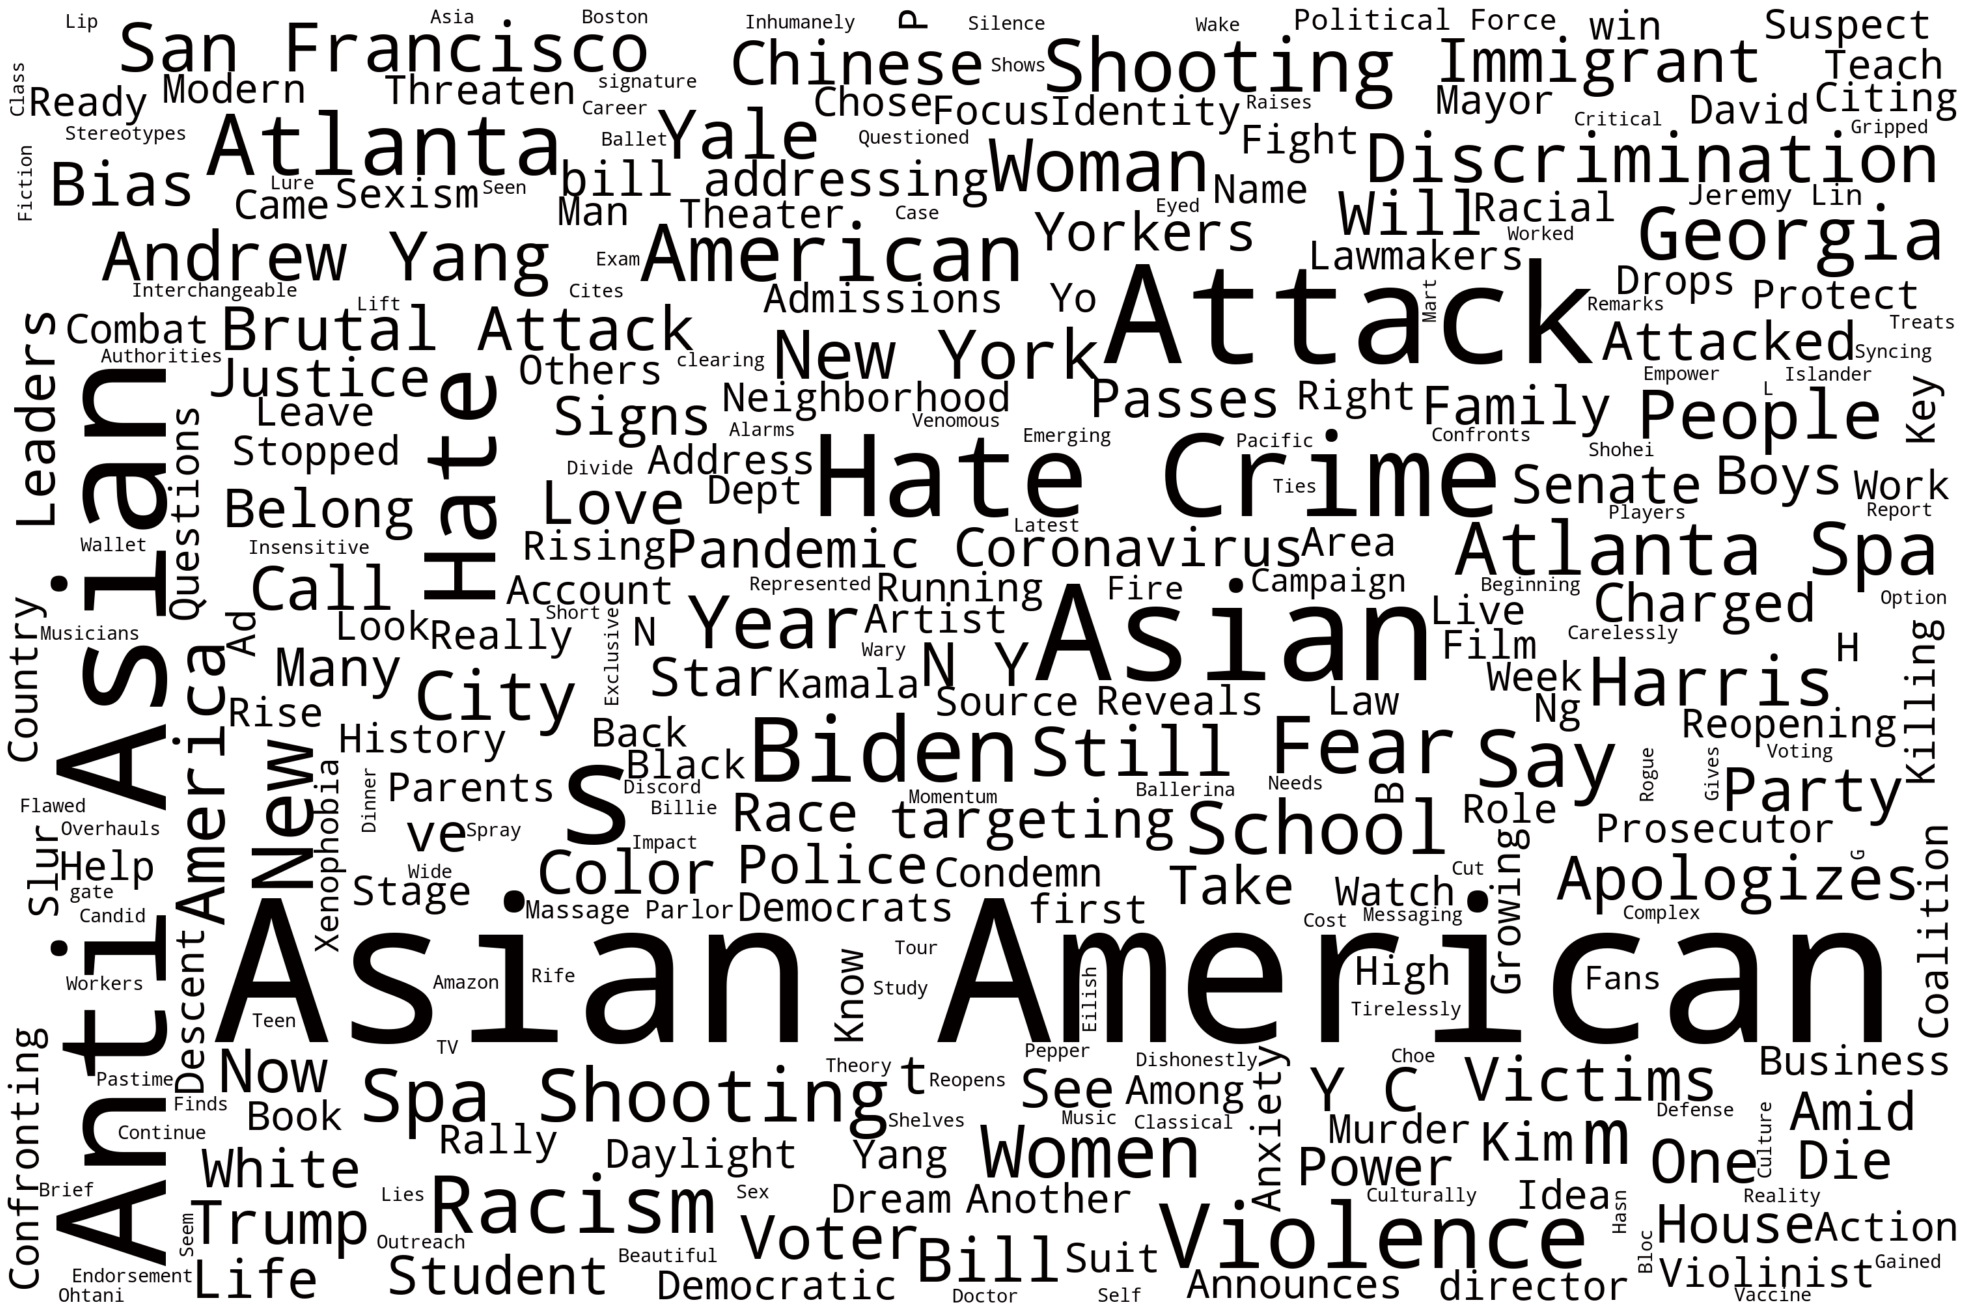

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Imported from the article in https://towardsdatascience.com/how-to-make-word-clouds-in-python-that-dont-suck-86518cdcb61f
# change the value to black

def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    # Function to create color visualizations
    return("hsl(0,100%, 1%)")

headlines = " ".join(" ".join(headline.split(" ")) for headline in updatedData["headline"])
cloud = WordCloud(background_color="white", width=3000, height=2000, max_words=300).generate_from_text(headlines)
cloud.recolor(color_func=black_color_func)

plt.figure(figsize=[35, 30])
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('Pandemic Word Cloud.png')
plt.show()

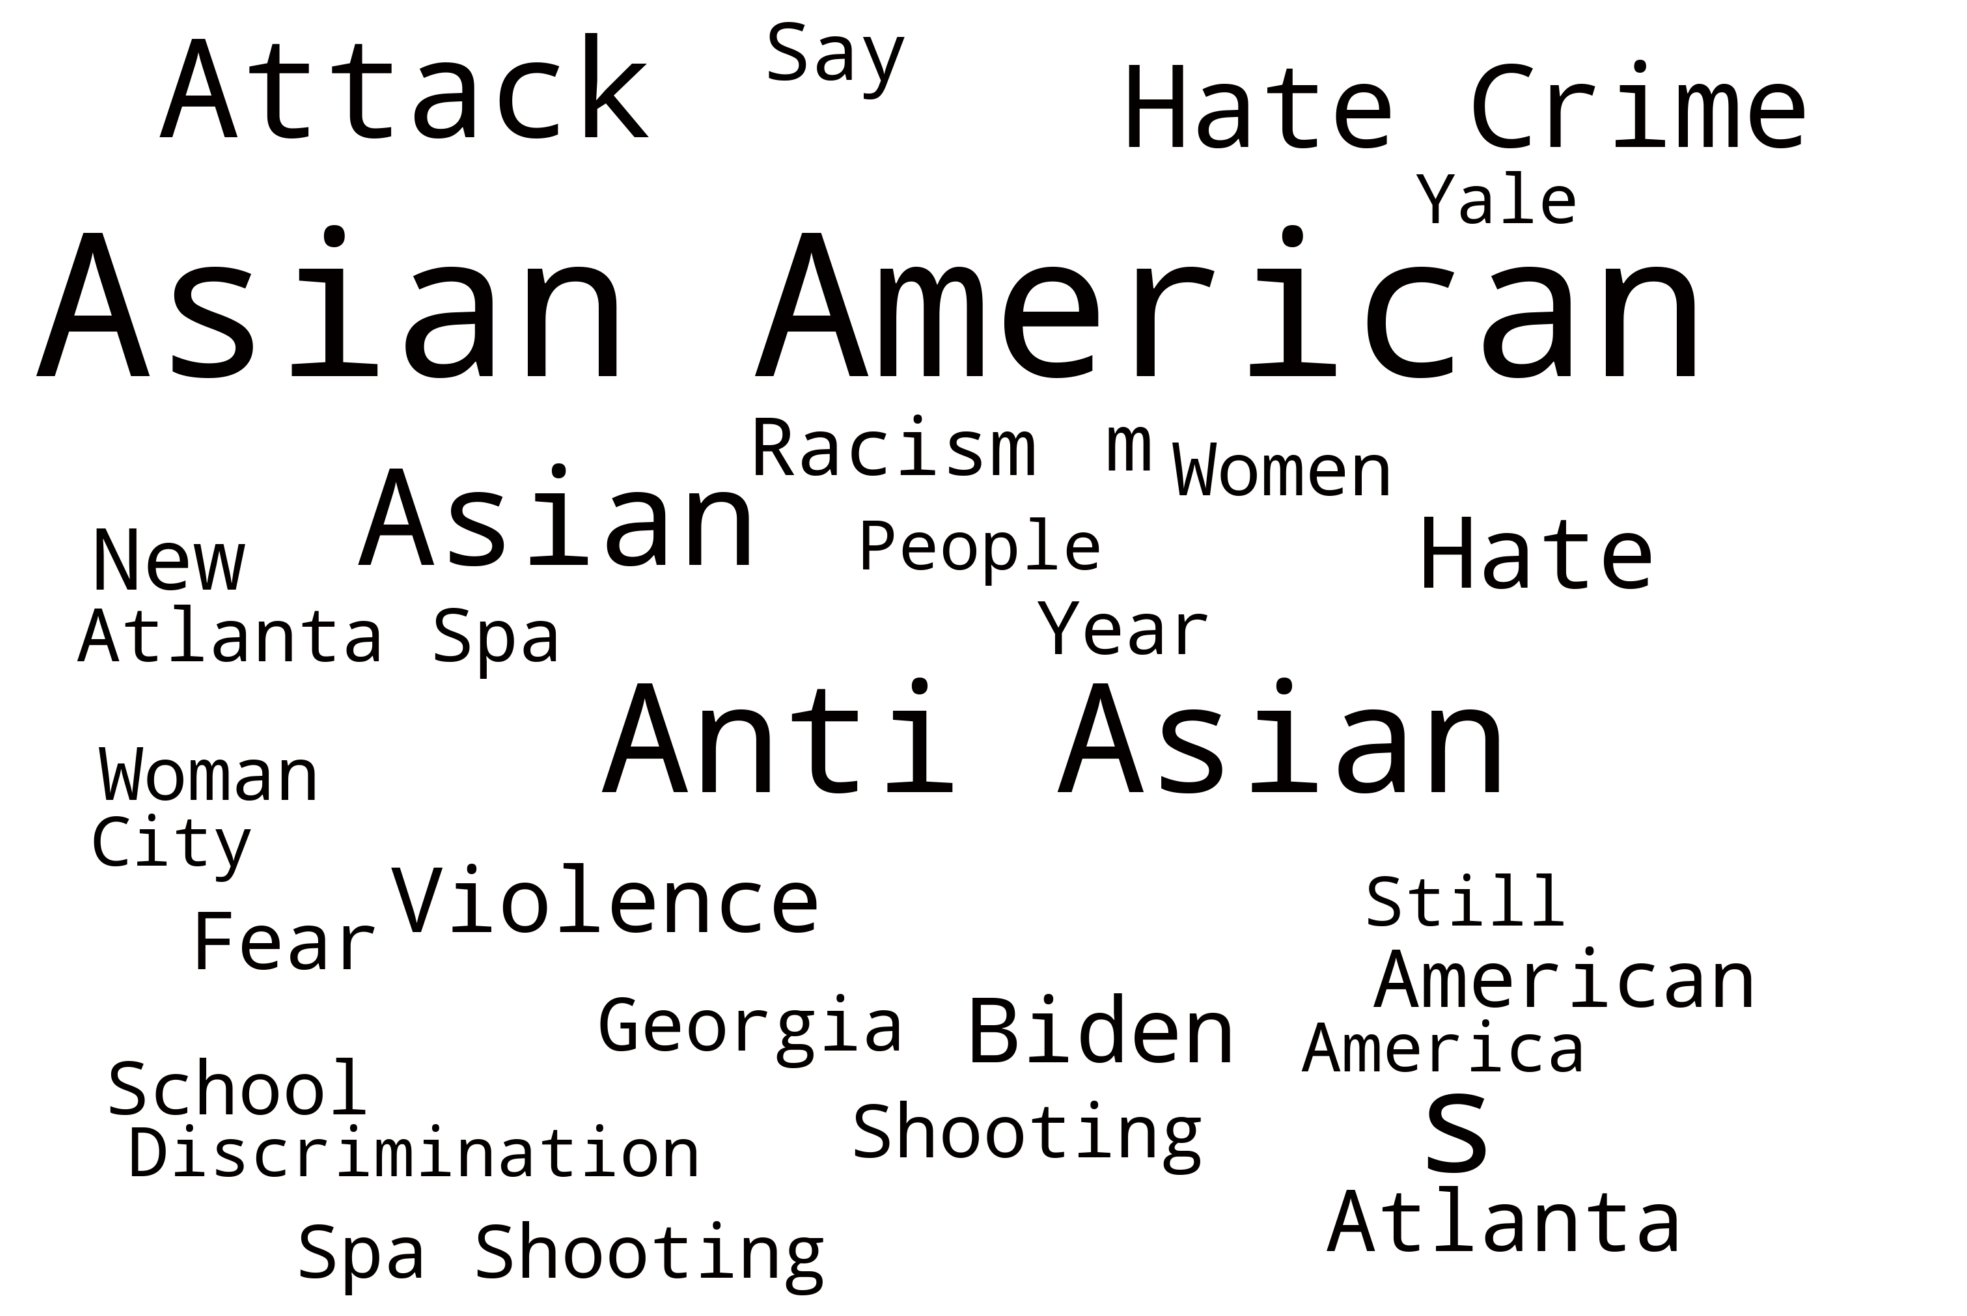

In [19]:
cloud = WordCloud(background_color="white", width=3000, height=2000, max_words=30).generate_from_text(headlines)
cloud.recolor(color_func=black_color_func)

plt.figure(figsize=[35, 30])
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('Pandemic Limited Word Cloud.png')
plt.show()

### Generate Wordcloud with All Headlines

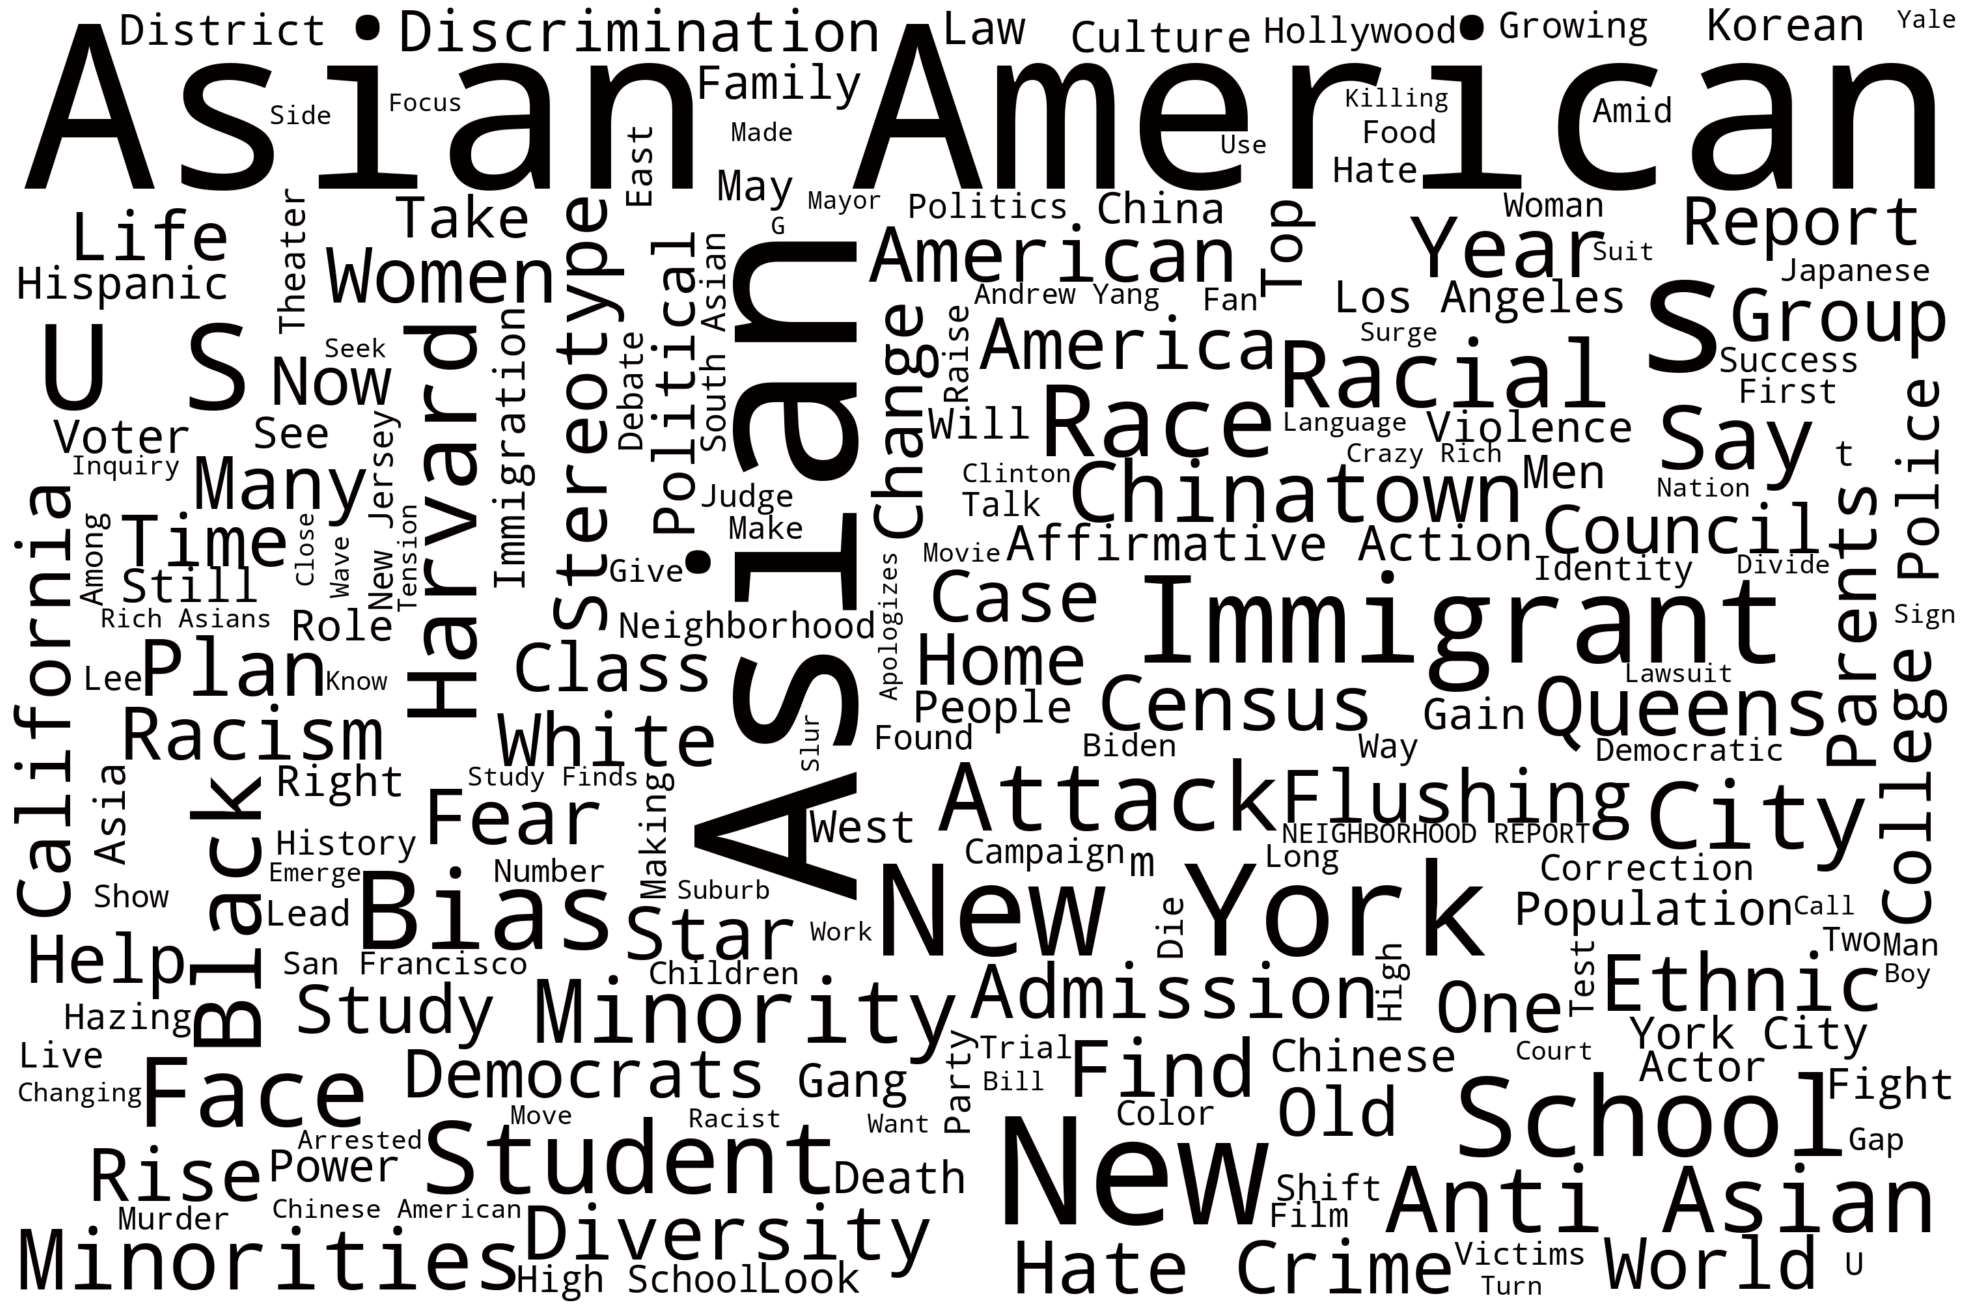

In [20]:
allData = pd.read_csv("Asians American NYT Dataset.csv")
all = " ".join(headline for headline in allData["headline"])
cloud = WordCloud(background_color="white", width=3000, height=2000).generate_from_text(all)
cloud.recolor(color_func=black_color_func)
plt.figure(figsize=[35, 30])
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('All Word Cloud.png')
plt.show()

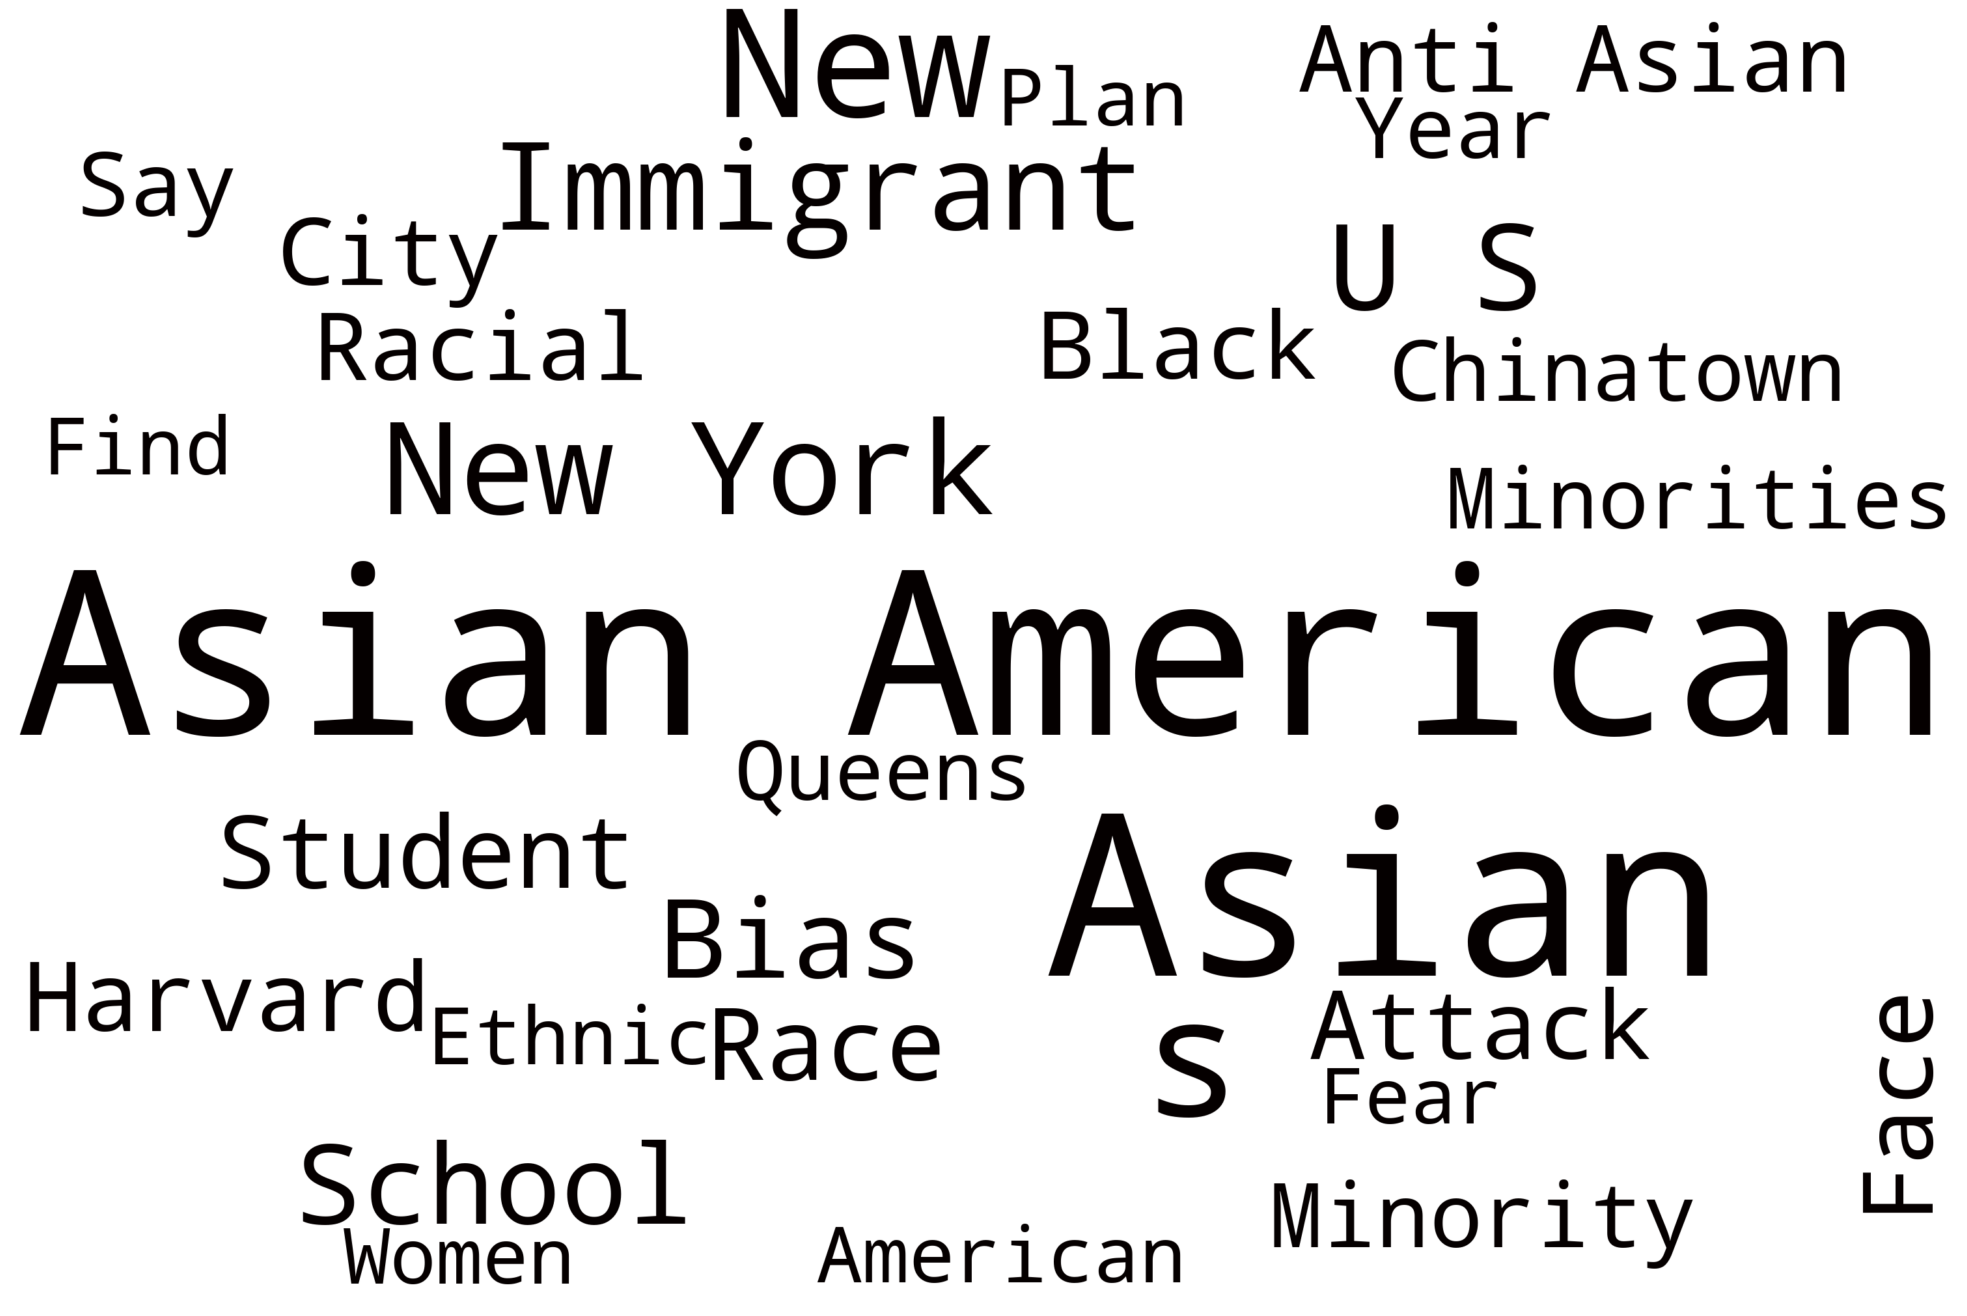

In [21]:
cloud = WordCloud(background_color="white", width=3000, height=2000, max_words=30).generate_from_text(all)
cloud.recolor(color_func=black_color_func)
plt.figure(figsize=[35, 30])
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('All Limited Word Cloud.png')
plt.show()

## Exploratory Analysis
### Update the date aggregrated data with the US Covid Cases

In [49]:
covidData = pd.read_csv("us.csv")
print(covidData.dtypes)

date      object
cases      int64
deaths     int64
dtype: object


In [54]:
merged = pd.merge(covidData, updatedData, on=["date"])
merged = merged.drop(['headline', 'news_desk', 'url'], axis=1)
trend = [0] * len(merged)
trend[0] = 1
for i in range(1, len(merged)):
    if merged["cases"][i - 1] == merged["cases"][i]:
        continue
    elif merged["cases"][i - 1] < merged["cases"][i]:
        trend[i] = 1
    else:
        trend[i] = -1

merged["trend"] = trend

# Choose the date beginning of the pandemic in the US from https://www.census.gov/popclock/

citizen = 331211595

merged["rate_cases"] = [0] * len(merged)
merged["rate_death"] = [0] * len(merged)
for i, item in enumerate(merged["cases"]):
    merged.loc[i, "rate_cases"] = item / 1000
    merged.loc[i,"rate_death"] = merged.loc[i,"deaths"] / 1000
    merged.loc[i,"deaths"] = merged.loc[i,"deaths"] * 100 / item
    merged.loc[i,"cases"] = item * 100 / citizen
merged.head(10)

date         cases  deaths  word_count  Hate Crimes  Discrimination  \
0  2020-01-25  9.057654e-07     0.0       927.0          0.0             0.0   
1  2020-01-30  1.811531e-06     0.0       327.0          0.0             0.0   
2  2020-01-31  2.113453e-06     0.0      3156.0          0.0             0.0   
3  2020-02-11  3.924983e-06     0.0      1075.0          0.0             0.0   
4  2020-02-12  4.226905e-06     0.0      1408.0          0.0             0.0   
5  2020-02-12  4.226905e-06     0.0      1254.0          0.0             0.0   
6  2020-02-14  4.528827e-06     0.0      1176.0          0.0             1.0   
7  2020-02-15  4.528827e-06     0.0      1251.0          0.0             0.0   
8  2020-02-16  4.528827e-06     0.0      1357.0          0.0             1.0   
9  2020-02-17  7.548045e-06     0.0       910.0          0.0             0.0   

   Race and Ethnicity  Atlanta Spa Shootings (2021)  \
0                 0.0                           0.0   
1                 0.0                           0.0   
2                 0.0                           0.0   
3                 0.0                           0.0   
4                 0.0                           0.0   
5                 0.0                           0.0   
6                 1.0                           0.0   
7                 1.0                           0.0   
8                 0.0                           0.0   
9                 0.0                           0.0   

   Murders, Attempted Murders and Homicides  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
5                                       0.0   
6                                       0.0   
7                                       0.0   
8                                       0.0   
9                                       0.0   

   Demonstrations, Protests and Riots  Mass Shootings  \
0                                 0.0             0.0   
1                                 0.0             0.0   
2                                 0.0             0.0   
3                                 0.0             0.0   
4                                 0.0             0.0   
5                                 0.0             0.0   
6                                 0.0             0.0   
7                                 0.0             0.0   
8                                 0.0             0.0   
9                                 0.0             0.0   

   Quarantine (Life and Culture)  Assaults  Minorities  \
0                            0.0       0.0         0.0   
1                            0.0       0.0         0.0   
2                            0.0       0.0         0.0   
3                            0.0       0.0         1.0   
4                            0.0       0.0         0.0   
5                            0.0       0.0         0.0   
6                            0.0       0.0         0.0   
7                            0.0       0.0         0.0   
8                            0.0       0.0         0.0   
9                            0.0       0.0         0.0   

   Workplace Hazards and Violations  Coronavirus (2019-nCoV)  trend  \
0                               0.0                      0.0      1   
1                               0.0                      0.0      1   
2                               0.0                      0.0      1   
3                               0.0                      0.0      1   
4                               0.0                      0.0      1   
5                               0.0                      0.0      0   
6                               0.0                      0.0      1   
7                               0.0                      0.0      0   
8                               0.0                      1.0      0   
9                          

In [78]:
pandemicData = merged.loc[:, merged.columns.intersection(["date", "rate_cases", "rate_death", "deaths", "cases"])].drop_duplicates()
pandemicData

date         cases    deaths  rate_cases  rate_death
0    2020-01-25  9.057654e-07  0.000000       0.003       0.000
1    2020-01-30  1.811531e-06  0.000000       0.006       0.000
2    2020-01-31  2.113453e-06  0.000000       0.007       0.000
3    2020-02-11  3.924983e-06  0.000000       0.013       0.000
4    2020-02-12  4.226905e-06  0.000000       0.014       0.000
..          ...           ...       ...         ...         ...
201  2021-07-14  1.024492e+01  1.791108   33932.356     607.765
204  2021-07-15  1.025567e+01  1.790225   33967.961     608.103
205  2021-07-18  1.027814e+01  1.787713   34042.378     608.580
206  2021-07-19  1.029499e+01  1.785463   34098.206     608.811
207  2021-07-21  1.033256e+01  1.781009   34222.629     609.508

[132 rows x 5 columns]

### Heat Map Visualization For Correlation
- Group by date

In [79]:
dateData = merged.drop(["rate_cases", "rate_death", "deaths", "cases"], axis=1).groupby(["date"]).sum()
dateData = pd.merge(pandemicData, dateData, on=["date"])
dateData

date         cases    deaths  rate_cases  rate_death  word_count  \
0    2020-01-25  9.057654e-07  0.000000       0.003       0.000       927.0   
1    2020-01-30  1.811531e-06  0.000000       0.006       0.000       327.0   
2    2020-01-31  2.113453e-06  0.000000       0.007       0.000      3156.0   
3    2020-02-11  3.924983e-06  0.000000       0.013       0.000      1075.0   
4    2020-02-12  4.226905e-06  0.000000       0.014       0.000      2662.0   
..          ...           ...       ...         ...         ...         ...   
127  2021-07-14  1.024492e+01  1.791108   33932.356     607.765      4204.0   
128  2021-07-15  1.025567e+01  1.790225   33967.961     608.103      1480.0   
129  2021-07-18  1.027814e+01  1.787713   34042.378     608.580      1387.0   
130  2021-07-19  1.029499e+01  1.785463   34098.206     608.811      1516.0   
131  2021-07-21  1.033256e+01  1.781009   34222.629     609.508      3566.0   

     Hate Crimes  Discrimination  Race and Ethnicity  \
0            0.0             0.0                 0.0   
1            0.0             0.0                 0.0   
2            0.0             0.0                 0.0   
3            0.0             0.0                 0.0   
4            0.0             0.0                 0.0   
..           ...             ...                 ...   
127          2.0             1.0                 1.0   
128          0.0             0.0                 1.0   
129          1.0             1.0                 0.0   
130          0.0             0.0                 0.0   
131          0.0             2.0                 2.0   

     Atlanta Spa Shootings (2021)  Murders, Attempted Murders and Homicides  \
0                             0.0                                       0.0   
1                             0.0                                       0.0   
2                             0.0                                       0.0   
3                             0.0                                       0.0   
4                             0.0                                       0.0   
..                            ...                                       ...   
127                           0.0                                       0.0   
128                           0.0                                       0.0   
129                           0.0                                       0.0   
130                           0.0                                       0.0   
131                           0.0                                       0.0   

     Demonstrations, Protests and Riots  Mass Shootings  \
0                                   0.0             0.0   
1                                   0.0             0.0   
2                                   0.0             0.0   
3                                   0.0             0.0   
4                                   0.0             0.0   
..                                  ...             ...   
127                                 0.0             0.0   
128                                 0.0             0.0   
129                                 0.0             0.0   
130                                 0.0             0.0   
131                                 0.0             0.0   

     Quarantine (Life and Culture)  Assaults  Minorities  \
0                              0.0       0.0         0.0   
1                              0.0       0.0         0.0   
2                              0.0       0.0         0.0   
3                              0.0       0.0         1.0   
4                              0.0       0.0         0.0   
..                             ...       ...         ...   
127                            0.0       1.0         0.0   
128                            0.0       0.0         0.0   
129                            0.0       1.0         0.0   
130                            0.0       0.0         0.0   
131                            0.0       0.0         0.0   

     Workp

In [80]:
heatmap = dateData
for i in range(1, len(dateData)):
    for tag in tags:
        heatmap.loc[i, tag] += heatmap.loc[i - 1, tag]

heatmap.head(20)

date         cases    deaths  rate_cases  rate_death  word_count  \
0   2020-01-25  9.057654e-07  0.000000       0.003       0.000       927.0   
1   2020-01-30  1.811531e-06  0.000000       0.006       0.000       327.0   
2   2020-01-31  2.113453e-06  0.000000       0.007       0.000      3156.0   
3   2020-02-11  3.924983e-06  0.000000       0.013       0.000      1075.0   
4   2020-02-12  4.226905e-06  0.000000       0.014       0.000      2662.0   
5   2020-02-14  4.528827e-06  0.000000       0.015       0.000      1176.0   
6   2020-02-15  4.528827e-06  0.000000       0.015       0.000      1251.0   
7   2020-02-16  4.528827e-06  0.000000       0.015       0.000      1357.0   
8   2020-02-17  7.548045e-06  0.000000       0.025       0.000       910.0   
9   2020-02-19  7.548045e-06  0.000000       0.025       0.000       520.0   
10  2020-03-03  3.774022e-05  8.000000       0.125       0.010      1566.0   
11  2020-03-12  5.036056e-04  2.577938       1.668       0.043       446.0   
12  2020-03-19  3.741717e-03  1.710643      12.393       0.212      1064.0   
13  2020-03-23  1.313511e-02  1.330882      43.505       0.579      2468.0   
14  2020-03-28  3.742804e-02  1.855347     123.966       2.300      1181.0   
15  2020-03-29  4.301963e-02  1.907556     142.486       2.718      1517.0   
16  2020-04-04  9.435811e-02  3.035917     312.525       9.488      1160.0   
17  2020-04-10  1.507755e-01  4.221985     499.386      21.084      4533.0   
18  2020-04-12  1.685475e-01  4.451240     558.249      24.849      2860.0   
19  2020-04-13  1.763278e-01  4.556880     584.018      26.613         0.0   

    Hate Crimes  Discrimination  Race and Ethnicity  \
0           0.0             0.0                 0.0   
1           0.0             0.0                 0.0   
2           0.0             0.0                 0.0   
3           0.0             0.0                 0.0   
4           0.0             0.0                 0.0   
5           0.0             1.0                 1.0   
6           0.0             1.0                 2.0   
7           0.0             2.0                 2.0   
8           0.0             2.0                 2.0   
9           0.0             2.0                 2.0   
10          0.0             3.0                 2.0   
11          0.0             3.0                 2.0   
12          0.0             4.0                 3.0   
13          1.0             6.0                 4.0   
14          1.0             6.0                 4.0   
15          1.0             7.0                 5.0   
16          1.0             7.0                 5.0   
17          1.0             9.0                 5.0   
18          1.0            10.0                 6.0   
19          1.0            10.0                 6.0   

    Atlanta Spa Shootings (2021)  Murders, Attempted Murders and Homicides  \
0                            0.0                                       0.0   
1                            0.0                                       0.0   
2                            0.0                                       0.0   
3                            0.0                                       0.0   
4                            0.0                                       0.0   
5                            0.0                                       0.0   
6                            0.0                                       0.0   
7                            0.0                                       0.0   
8                            0.0                                       0.0   
9                            0.0                                       0.0   
10                           0.0                                       0.0   
11                           0.0                                       0.0   
12                           0.0                                       0.0   
13                           0.0                                       0.0   
14                           0.0             

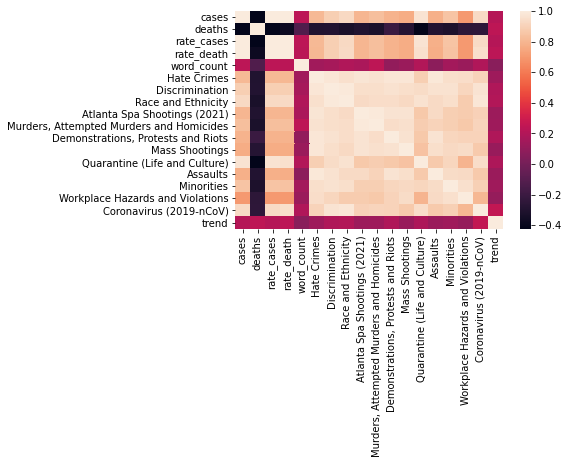

In [81]:
%matplotlib inline
import seaborn as sns

correlations = heatmap.corr()
sns.heatmap(correlations)
plt.savefig("Correlation Heat Map")
plt.show()

#### Correlations for cases per total US populations

In [82]:
correlations["cases"]

cases                                       1.000000
deaths                                     -0.421852
rate_cases                                  1.000000
rate_death                                  0.994964
word_count                                  0.234774
Hate Crimes                                 0.813386
Discrimination                              0.888925
Race and Ethnicity                          0.930256
Atlanta Spa Shootings (2021)                0.804133
Murders, Attempted Murders and Homicides    0.836923
Demonstrations, Protests and Riots          0.791835
Mass Shootings                              0.771186
Quarantine (Life and Culture)               0.969540
Assaults                                    0.781444
Minorities                                  0.850155
Workplace Hazards and Violations            0.703027
Coronavirus (2019-nCoV)                     0.936542
trend                                       0.213424
Name: cases, dtype: float64

#### Correlations for death per 1000

In [83]:
correlations["rate_death"]

cases                                       0.994964
deaths                                     -0.374497
rate_cases                                  0.994964
rate_death                                  1.000000
word_count                                  0.232179
Hate Crimes                                 0.810146
Discrimination                              0.894284
Race and Ethnicity                          0.934621
Atlanta Spa Shootings (2021)                0.801298
Murders, Attempted Murders and Homicides    0.835010
Demonstrations, Protests and Riots          0.794346
Mass Shootings                              0.768451
Quarantine (Life and Culture)               0.960888
Assaults                                    0.776886
Minorities                                  0.845450
Workplace Hazards and Violations            0.700259
Coronavirus (2019-nCoV)                     0.954221
trend                                       0.237364
Name: rate_death, dtype: float64

#### Correlations for percentages of deaths over cases

In [84]:
correlations["deaths"]

cases                                      -0.421852
deaths                                      1.000000
rate_cases                                 -0.421852
rate_death                                 -0.374497
word_count                                 -0.126500
Hate Crimes                                -0.296197
Discrimination                             -0.291328
Race and Ethnicity                         -0.326621
Atlanta Spa Shootings (2021)               -0.298806
Murders, Attempted Murders and Homicides   -0.318378
Demonstrations, Protests and Riots         -0.204335
Mass Shootings                             -0.282699
Quarantine (Life and Culture)              -0.418001
Assaults                                   -0.292104
Minorities                                 -0.313824
Workplace Hazards and Violations           -0.252557
Coronavirus (2019-nCoV)                    -0.249162
trend                                       0.239284
Name: deaths, dtype: float64

#### Correlations for cases per 1000

In [85]:
correlations["rate_cases"]

cases                                       1.000000
deaths                                     -0.421852
rate_cases                                  1.000000
rate_death                                  0.994964
word_count                                  0.234774
Hate Crimes                                 0.813386
Discrimination                              0.888925
Race and Ethnicity                          0.930256
Atlanta Spa Shootings (2021)                0.804133
Murders, Attempted Murders and Homicides    0.836923
Demonstrations, Protests and Riots          0.791835
Mass Shootings                              0.771186
Quarantine (Life and Culture)               0.969540
Assaults                                    0.781444
Minorities                                  0.850155
Workplace Hazards and Violations            0.703027
Coronavirus (2019-nCoV)                     0.936542
trend                                       0.213424
Name: rate_cases, dtype: float64

### Cases percentage versus the count for the article

In [ ]:
for tag in tags:
    sns.lineplot(data=dateData, x=tag, y="cases", markers=True)
    plt.show()

### Death percentage versus the count for the article

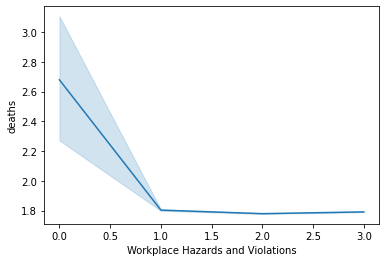

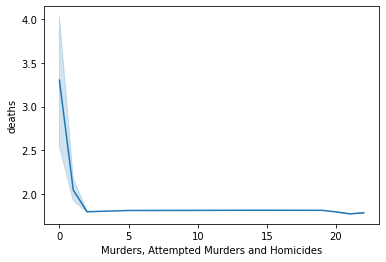

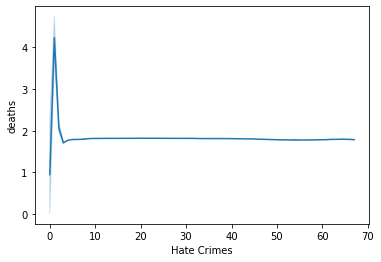

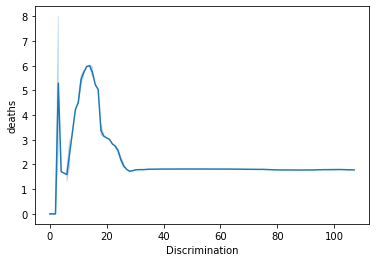

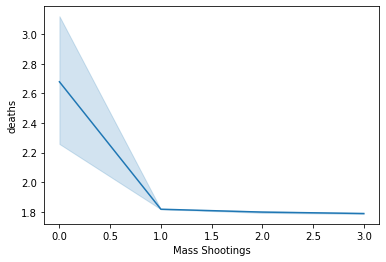

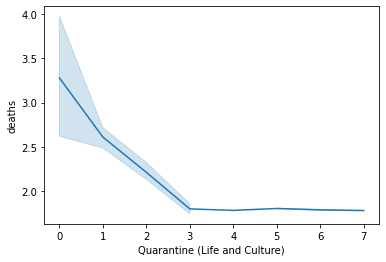

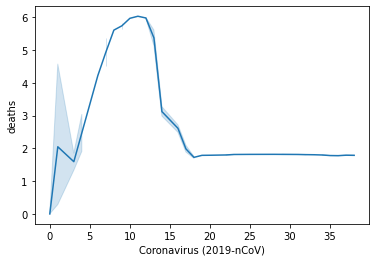

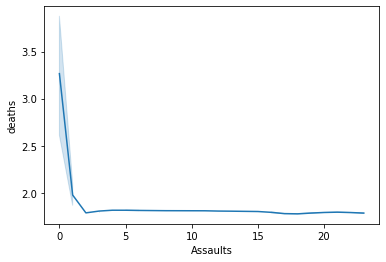

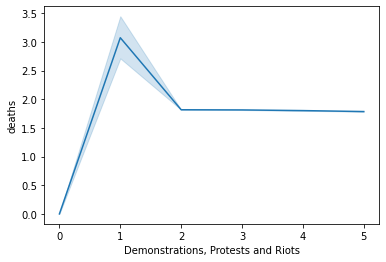

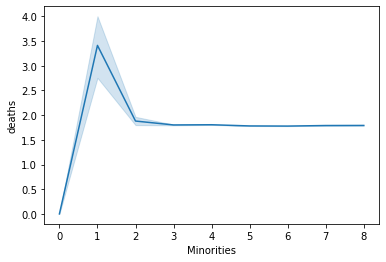

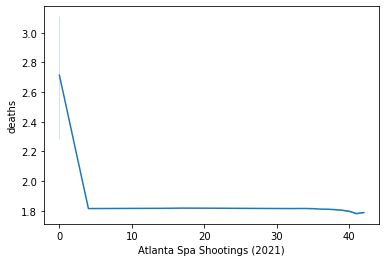

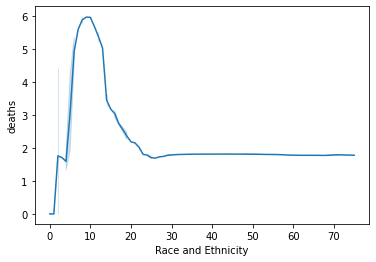

In [94]:
for tag in tags:
    sns.lineplot(data=dateData, x=tag, y="deaths", markers=True)
    plt.show()

#### Create Count For The Program

In [152]:
import numpy as np
total = len(updatedData)
# Published
pub = ["yes", "no"] * len(tags)
tagList = []
# Double the tags and create the list
for tag in tags:
    tagList.append(tag)
    tagList.append(tag)
count = [0] * len(tags) * 2
for i in range(len(tags) * 2):
    if i % 2 == 0:
        count[i] = heatmap.iloc[-1, :][tagList[i // 2]]
    else:
        count[i] = total - count[i - 1]
frame = pd.DataFrame({"Subject": tagList, "Published": pub, "Count": count})
frame

Subject Published  Count
0           Workplace Hazards and Violations       yes    3.0
1           Workplace Hazards and Violations        no  207.0
2   Murders, Attempted Murders and Homicides       yes    3.0
3   Murders, Attempted Murders and Homicides        no  207.0
4                                Hate Crimes       yes   22.0
5                                Hate Crimes        no  188.0
6                             Discrimination       yes   22.0
7                             Discrimination        no  188.0
8                             Mass Shootings       yes   67.0
9                             Mass Shootings        no  143.0
10             Quarantine (Life and Culture)       yes   67.0
11             Quarantine (Life and Culture)        no  143.0
12                   Coronavirus (2019-nCoV)       yes  107.0
13                   Coronavirus (2019-nCoV)        no  103.0
14                                  Assaults       yes  107.0
15                                  Assaults        no  103.0
16        Demonstrations, Protests and Riots       yes    3.0
17        Demonstrations, Protests and Riots        no  207.0
18                                Minorities       yes    3.0
19                                Minorities        no  207.0
20              Atlanta Spa Shootings (2021)       yes    7.0
21              Atlanta Spa Shootings (2021)        no  203.0
22                        Race and Ethnicity       yes    7.0
23                        Race and Ethnicity        no  203.0

In [153]:
iterables = [list(tags), ["yes", "no"]]
index = pd.MultiIndex.from_product(iterables, names=["Subjects", "Published"])
index
countTag = pd.DataFrame(index=index, data=count, columns=["Count"])
countTag

Count
Subjects                                 Published       
Workplace Hazards and Violations         yes          3.0
                                         no         207.0
Murders, Attempted Murders and Homicides yes          3.0
                                         no         207.0
Hate Crimes                              yes         22.0
                                         no         188.0
Discrimination                           yes         22.0
                                         no         188.0
Mass Shootings                           yes         67.0
                                         no         143.0
Quarantine (Life and Culture)            yes         67.0
                                         no         143.0
Coronavirus (2019-nCoV)                  yes        107.0
                                         no         103.0
Assaults                                 yes        107.0
                                         no         103.0
Demonstrations, Protests and Riots       yes          3.0
                                         no         207.0
Minorities                               yes          3.0
                                         no         207.0
Atlanta Spa Shootings (2021)             yes          7.0
                                         no         203.0
Race and Ethnicity                       yes          7.0
                                         no         203.0

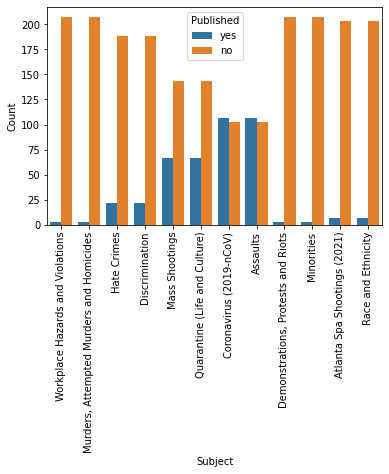

In [154]:
plot = sns.barplot(x="Subject", y="Count", hue="Published", data=frame)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.savefig("Count Published by Tags from Jan 21, 2020")
plt.show()